In [1]:
# loading for Google drive. 
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/DL_Project
# %ls

%load_ext autoreload
%autoreload 2
# imports
import numpy as np
from PIL import Image
import os
from loader import ImageData
from models import ClassificationCNN, Unet
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from losses import reweight, FocalLoss
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(device)

mps


### Helper function for calculating performance metrics

In [2]:
def initialize_metrics(num_classes):
    return {
        'TP': torch.zeros(num_classes),
        'FP': torch.zeros(num_classes),
        'FN': torch.zeros(num_classes),
    }

def update_metrics(metrics, preds, targets, num_classes):
    for cls in range(num_classes):
        pred_cls = (preds == cls)
        true_cls = (targets == cls)

        metrics['TP'][cls] += torch.sum(pred_cls & true_cls).item()
        metrics['FP'][cls] += torch.sum(pred_cls & ~true_cls).item()
        metrics['FN'][cls] += torch.sum(~pred_cls & true_cls).item()

def compute_final_metrics(metrics):
    eps = 1e-8  # for numerical stability
    precision = metrics['TP'] / (metrics['TP'] + metrics['FP'] + eps)
    recall = metrics['TP'] / (metrics['TP'] + metrics['FN'] + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    iou = metrics['TP'] / (metrics['TP'] + metrics['FP'] + metrics['FN'] + eps)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'iou': iou
    }

#### Creating dataloaders for Model training

In [2]:
from sklearn.model_selection import train_test_split
tumor_type = ["Astrocytoma", "Glioblastoma", "Gliomas", "Meningioma"]
image_type = ["images", "masks"]

full_mask_paths = []
full_image_paths = []
full_labels = []

label_tag = 1
for tumor in tumor_type:
    image_folder_path = f"./Brain Tumor Classification 2D/{tumor}/images" # change this appropriately
    mask_folder_path = f"./Brain Tumor Classification 2D/{tumor}/masks" # change this approperiately.
    img_file_names = os.listdir(image_folder_path)
    image_paths = [f"{image_folder_path}/{i}" for i in img_file_names if i != ".DS_Store"]
    image_paths.sort()

    mask_file_names = os.listdir(mask_folder_path)
    mask_paths = [f"{mask_folder_path}/{i}" for i in mask_file_names if i != ".DS_Store"]
    mask_paths.sort()
    print(f"{tumor}: No. of images: {len(image_paths)} || No. of masks: {len(mask_paths)}")

    labels = len(image_paths)*[label_tag]

    full_image_paths = full_image_paths + image_paths
    full_mask_paths = full_mask_paths + mask_paths
    full_labels = full_labels + labels

    label_tag += 1

compact_labels = [[i, j] for i, j in zip(full_mask_paths, full_labels)]

train_image_paths, val_image_paths, compact_train_labels, compact_val_labels = train_test_split(full_image_paths,
                                                                                                compact_labels,
                                                                                                test_size=0.2,
                                                                                                random_state=42)

train_masks_paths, train_labels = zip(*compact_train_labels)
train_masks_paths = list(train_masks_paths)
train_labels = list(train_labels)

val_masks_paths, val_labels = zip(*compact_val_labels)
val_masks_paths = list(val_masks_paths)
val_labels = list(val_labels)

train_data = ImageData(train_image_paths, train_labels, train_masks_paths)
val_data = ImageData(val_image_paths, val_labels, val_masks_paths)

dataloader_train = DataLoader(train_data, batch_size=64, shuffle=True)
dataloader_val = DataLoader(val_data, batch_size=64, shuffle=True)

print(f"train size: {len(train_data)} || val size: {len(val_data)}")

Astrocytoma: No. of images: 529 || No. of masks: 529
Glioblastoma: No. of images: 732 || No. of masks: 732
Gliomas: No. of images: 1237 || No. of masks: 1237
Meningioma: No. of images: 640 || No. of masks: 640
train size: 2510 || val size: 628


tumor type: Glioblastoma


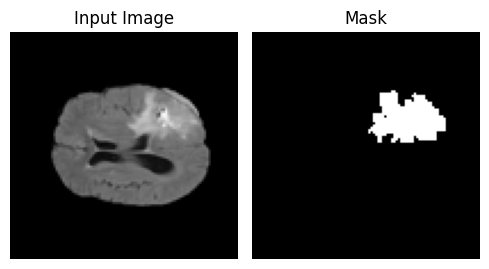

In [3]:
img, mask = val_data[28]
print(f"tumor type: {tumor_type[mask.max().item()-1]}")

fig, axs = plt.subplots(1, 2, figsize=(5, 3))
axs[0].imshow(img.reshape((100, 100)), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')
axs[1].imshow(mask.reshape((100, 100)), cmap='gray')
axs[1].set_title('Mask')
axs[1].axis('off')
plt.tight_layout()
plt.show()

### Training Loop

In [8]:
model = Unet().to(device)

weights = torch.tensor([0.1, 1.0, 1.0, 1.0, 1.0], device=device) #manual weights assigned

criterion = FocalLoss(weight=weights, gamma=1.5)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,             
    weight_decay=0       # for regularization
)

## TRAINING LOOP
val_loss_series = []
train_loss_series = []
final_iou_all_series = []
final_iou_tumor_series = []

epochs =  85
for epoch in range(epochs):
    # train
    iteration = 0
    train_loss = 0
    print(f"----epoch: {epoch}-----")
    for x, y in dataloader_train:
        if iteration % 10 == 0:
            print(f"images processed, {64*iteration}")
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        out = model(x)
        print(out.shape)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        iteration += 1

    train_loss_series.append(train_loss/len(dataloader_train))
    print(f"train loss: {loss.item()}")
    
    ## validation
    with torch.no_grad():
        num_classes = 5
        metrics = initialize_metrics(num_classes)
        val_loss = 0
        for x_val, y_val in dataloader_val:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            score = model(x_val)
            preds = torch.argmax(score, dim=1)
            update_metrics(metrics, preds, y_val, num_classes)
            val_loss += criterion(score, y_val).item()
        
        final_metrics = compute_final_metrics(metrics)
        iou_all_class = final_metrics['iou'].mean().item()
        iou_tumor_only = final_metrics['iou'][1:5].mean().item()
        final_iou_all_series.append(iou_all_class)
        final_iou_tumor_series.append(iou_tumor_only)
        val_loss_series.append(val_loss/len(dataloader_val))

        print(f"validation loss: {val_loss/len(dataloader_val)}\n")

----epoch: 0-----
images processed, 0
torch.Size([64, 128, 96, 96])


RuntimeError: Size does not match at dimension 2 expected index [64, 1, 100, 100] to be no larger than self [64, 128, 96, 96] apart from dimension 1

#### Data Analysis

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec

x = np.linspace(1, epochs, epochs)

# Use GridSpec to control layout
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])  # last col for colorbar

import matplotlib.pyplot as plt

# Subplot 1 - Loss Curves
ax0 = plt.subplot(gs[0])
ax0.plot(x, val_loss_series, label="Validation Loss")
ax0.plot(x, train_loss_series, label="Training Loss")
ax0.set_title("Loss Curves")
ax0.set_xlabel("Epochs")
ax0.set_ylabel("CE Loss")
ax0.legend()

# Subplot 2 - Dice Index
ax1 = plt.subplot(gs[1])
ax1.plot(x, final_iou_all_series, label="Average IoU - All")
ax1.plot(x, final_iou_tumor_series, label="Average IoU - Tumor")
ax1.set_title("Dice Index")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("IoU")
ax1.legend()

### matrics after the training 
for cls in range(num_classes):
    print(f"Class {cls}: Precision={final_metrics['precision'][cls]:.3f}, "
          f"Recall={final_metrics['recall'][cls]:.3f}, "
          f"F1={final_metrics['f1'][cls]:.3f}, "
          f"IoU={final_metrics['iou'][cls]:.3f}")

### Load the best model

In [135]:
## Load the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
initial_weights = torch.load('./checkpoints/unet_small_best_model_leakyrelu.pth')
#initial_weights = torch.load('./checkpoints/unet_small_best_model.pth')
model = Unet().to(device)
model.load_state_dict(initial_weights)

<All keys matched successfully>

#### Hook handles for analyzing hidden layers

In [117]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

hook_handle = model.conv1.register_forward_hook(get_activation('conv1'))
hook_handle = model.conv2.register_forward_hook(get_activation('conv2'))
hook_handle = model.pool1.register_forward_hook(get_activation('pool1'))
hook_handle = model.pool2.register_forward_hook(get_activation('pool2'))
hook_handle = model.conv3.register_forward_hook(get_activation('conv3'))
hook_handle = model.conv5.register_forward_hook(get_activation('conv5'))
hook_handle = model.deconv5.register_forward_hook(get_activation('deconv5'))
hook_handle = model.deconv7.register_forward_hook(get_activation('deconv7'))
hook_handle = model.conv2_prime.register_forward_hook(get_activation('conv2_prime'))
hook_handle = model.conv3_prime.register_forward_hook(get_activation('conv3_prime'))
hook_handle = model.conv4_prime.register_forward_hook(get_activation('conv4_prime'))


#hook_handle.remove()

### Single image prediction

Actual tumor type: Astrocytoma
Predicted tumor type: Astrocytoma


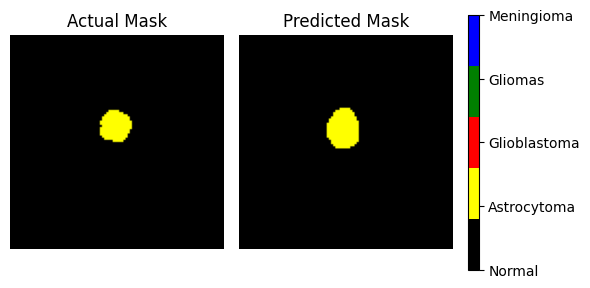

In [150]:
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec


tumor_type_plot = ["Normal", "Astrocytoma", "Glioblastoma", "Gliomas", "Meningioma"]

img, mask_actual = val_data[2]

print(f"Actual tumor type: {tumor_type[mask_actual.max().item() - 1]}")

mask_predicted = model(img.unsqueeze(0).to(device)) # predict
mask_predicted = torch.argmax(mask_predicted, dim=1).detach().cpu().squeeze().long()
values, counts = torch.unique(mask_predicted, return_counts=True)
sorted_indices = torch.argsort(counts, descending=True)
second_most_frequent_class = values[sorted_indices[1]]

print(f"Predicted tumor type: {tumor_type[second_most_frequent_class.item() - 1]}")

cmap = ListedColormap([
    'black',   # Normal
    'yellow',  # Astrocytoma
    'red',     # Glioblastoma
    'green',   # Gliomas
    'blue'     # Meningioma
])

# Use GridSpec to control layout
fig = plt.figure(figsize=(6, 3))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])  # last col for colorbar

# Subplot 1 - Actual
ax0 = plt.subplot(gs[0])
im0 = ax0.imshow(mask_actual.reshape((100, 100)), cmap=cmap, vmin=0, vmax=4)
ax0.set_title("Actual Mask")
ax0.axis('off')

# Subplot 2 - Predicted
ax1 = plt.subplot(gs[1])
im1 = ax1.imshow(mask_predicted.reshape((100, 100)), cmap=cmap, vmin=0, vmax=4)
ax1.set_title("Predicted Mask")
ax1.axis('off')

# Colorbar in the third column
cbar_ax = plt.subplot(gs[2])
cbar = plt.colorbar(im1, cax=cbar_ax, ticks=[0, 1, 2, 3, 4])
cbar.ax.set_yticklabels(tumor_type_plot)

plt.tight_layout()
plt.show()



### Checkpoint

In [87]:
#torch.save(model.state_dict(), './checkpoints/unet_small_best_model_leakyrelu.pth')

### Predicting mask for collage of images

torch.Size([1, 200, 200])


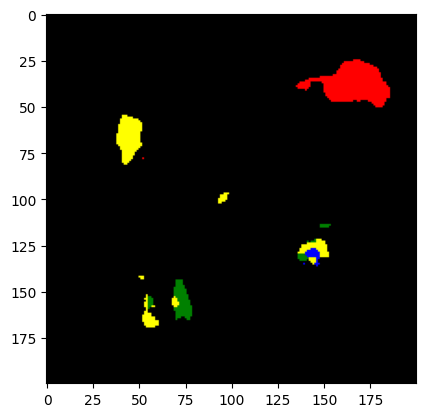

In [149]:
from utils import resize_image
test_image = Image.open("test_image2.png").convert("L")
test_image = resize_image(test_image, ideal_size=200)
test_array = torch.tensor(np.array(test_image, dtype=np.float32)).unsqueeze(0)
test_array = test_array/255
print(test_array.shape)
mask_predicted = model(test_array.unsqueeze(0).to(device))
mask_predicted = torch.argmax(mask_predicted, dim=1).detach().cpu().squeeze().long()

plt.imshow(mask_predicted.reshape((200, 200)), cmap=cmap, vmin=0, vmax=4)